# Smooth case (full)

Consider the following optimal control problem (Lagrange cost, fixed final time):
$$ \int_0^1 |u|^2\,\mathrm{d}t \to \min, $$
$$ \dot{q} = v, $$
$$ \dot{v} = -\lambda v^2 + u, $$
with $q$ and $v$ fixed at $t=0$ and $t=1$:
$$ q(0)=-1, v(0)=0, q(1)=0, v(1)=0. $$
Denoting $x=(q, v)$, the Lagrange cost functional is defined by
$$ f^0(t, x, u, \lambda) = u^2, $$
while the dynamics is
$$ f(t, x, u, \lambda) = (v, -\lambda v^2+u). $$

Denoting $p=(p_q,p_v)$, in the normal case ($p^0=-1/2$), the dynamic feedback is $u=p_v$, so the maximized Hamiltonian of the problem is
$$ H(t, x, p, \lambda) = p_v^2/2 + p_q v - \lambda p_v v^2. $$

## Initializations
 
To encode and solve the problem we use standard libraries such as `numpy` and `pyplot`, plus `nutopy`:

* `nutopy.nle` is a Nonlinear Equation solver

* `nutopy.tools` includes `@tensorize` and `@vectorize` decorators (see further)

* `nutopy.ocp` defines some useful classes and methods to manipulate optimal control problems and related stuff (Hamiltonians, flows...)

The initialization for the shooting method, an initial value for the unknown adjoint state $p_0$, is taken from `BOCOP` (also part of the
[ct](https://ct.gitlabpages.inria.fr/gallery) project).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from nutopy import nle
from nutopy.tools import *
from nutopy.ocp import *

t0 = 0.
x0 = np.array([ -1., 0. ])
lbda = 0.
tf = 1.
xf_fixed = np.array([ 0., 0. ]) # target is xf = (0, 0)
p0 = np.array([ 12.00120012, 6.00060006 ] ) - np.array([ 6., 7. ]) # from BOCOP (+/- some perturbation)

## Hamiltonian

The (normal and maximized) Hamiltonian is straightforwardly implemented, see `hfun`. The code requires that its first and second derivatives _wrt._ to state ($x$) and costate ($p$) are also provided. This derivatives, evaluated against first and second order increments are implemented by `dhfun` and `d2hfun`, respectively. These codes can be obtained through *automatic differentiation* for more complicated examples (see [here](https://ct.gitlabpages.inria.fr/gallery/kepler/kepler.html), _e.g._)

In [2]:
def dhfun(t, x, dx, p, dp, lbda):
    q, v = x
    pq, pv = p
    qd, vd = dx
    pqd, pvd = dp
    hd = 2*pv*pvd/2. + v*pqd + pq*vd - lbda*(v**2*pvd+pv*2*v*vd)
    return hd
    
def d2hfun(t, x, dx, d2x, p, dp, d2p, lbda):
    q, v = x
    pq, pv = p
    qd, vd = dx
    pqd, pvd = dp
    qd0, vd0 = d2x
    pqd0, pvd0 = d2p
    hdd = pvd*2*pvd0/2. + pqd*vd0 + vd*pqd0 - lbda*(pvd*2*v*vd0+vd*2*(v*pvd0+pv*vd0))
    return hdd

@tensorize(dhfun, d2hfun, tvars=(2, 3))
def hfun(t, x, p, lbda):
    q, v = x
    pq, pv = p
    h = pv**2/2. + pq*v - lbda*pv*v**2
    return h

h1 = Hamiltonian(hfun)

Note the use of the decorator `@tensorize` when defining `dhfun`, after having defined its first and second derivatives. Passing the _two_ positional arguments (`dhfun`, `d2hfun`) entails that `hfun` derivatives are provided up to order _two_, _wrt._ to variables specified by the named argument `tvars`: derivatives _wrt._ $x$ and $p$ (argument no. 2 and 3 of `hfun`, respectively). The decorated `hfun` function now contains its first and second derivative:

* to evaluate $H$ at $(t_0,x_0,p_0,\lambda)$,  type
```python
hfun(t0, x0, p0, lbda)
```

* to evaluate $\partial_x H$ at the same point evaluated against vector $\mathrm{d}x_0=(2.1,-3.2)$, type
```python
hfun(t0, (x0, dx0), p0, lbda)
```

* to evaluate $\partial^2_{px} H$ at the same point evaluated against vectors $\mathrm{d}x_0=(2.1,-3.2)$ and $\mathrm{d}p_0=(3.1,-7)$,
type
```python
hfun(t0, (x0, dx0, np.zeros(2)), (p0, np.zeros(2), dp0), lbda)
```

* and so on for further derivatives.

Having defined the object `h1` of class `Hamiltonian` allows to evaluate $H$ (`h1.val`), its symplectic gradient $\vec{H}$ (`h1.vec`), and [more](https://ct.gitlabpages.inria.fr/nutopy/api/ocp.html#nutopy.ocp.Hamiltonian).

In [3]:
dx0 = np.array([ 2.1, -3.2 ])
dp0 = np.array([ 3.1, -7 ])
print( hfun(t0, x0, p0, lbda) )
print( hfun(t0, (x0, dx0), p0, lbda) )
print( hfun(t0, (x0, dx0, np.zeros(2)), (p0, np.zeros(2), dp0), lbda) )
print( h1.val(t0, x0, p0, lbda) )
print( h1.vec(t0, x0, p0, lbda) )

0.49940012003600176
(0.49940012003600176, -19.203840384000003)
(0.49940012003600176, -19.203840384000003, -9.920000000000002)
0.49940012003600176
[ 0.         -0.99939994  0.         -6.00120012]


An alternative way of defining the maximized Hamiltonian is to set up an optimal control problem, that is an object of type [OCP](https://ct.gitlabpages.inria.fr/nutopy/api/ocp.html#nutopy.ocp.OCP), and then to use the class method [fromOCP](https://ct.gitlabpages.inria.fr/nutopy/api/ocp.html#nutopy.ocp.Hamiltonian.fromOCP). To set an `OCP`, the user needs to provide the function $f^0$ (Lagrange cost) and the dynamics $f$. These two functions are given below, as well as their derivatives up to order two. (Note the same use of `@tensorize` as before.) The user must also provide the _dynamic feedback_ that expresses $u$ as a function of $x$ and $p$, as a result of Hamiltonian maximization _wrt._ $u$. Here,
$$ u(x,p) = p_v. $$
In more complicated examples, there are several maximisers (including, _e.g._, bang and singular controls) and so several competing Hamiltonians to define using the same process. The expression `h2 = Hamiltonian.fromOCP(o, ufun, -0.5)` returns the (tensorized to order two) computation
$$ H(t,x,p) = p^0 f^0(t,x,u(x,p))+\langle p,f(t,x,u(x,p)) \rangle $$
with $p^0=-1/2$ (normal case). The resulting `Hamiltonian` object `h2` can be used exactly as the previously defined `h1`.

In [4]:
def df0fun(t, x, dx, u, du, lbda):
    df0 = 2.*u*du
    return df0

def d2f0fun(t, x, dx, d2x, u, du, d2u, lbda):
    d2f0 = 2.*d2u*du
    return d2f0

@tensorize(df0fun, d2f0fun, tvars=(2, 3))
def f0fun(t, x, u, lbda):
    f0 = u**2   
    return f0

def dffun(t, x, dx, u, du, lbda):
    q, v = x
    dq, dv = dx
    df = np.zeros(2)
    df[0] = dv
    df[1] = -lbda*2.*v*dv + du
    return df

def d2ffun(t, x, dx, d2x, u, du, d2u, lbda):
    q, v = x
    dq, dv = dx
    d2q, d2v = d2x
    d2f = np.zeros(2)
    d2f[0] = 0
    d2f[1] = -lbda*2.*d2v*dv
    return d2f

@tensorize(dffun, d2ffun, tvars=(2, 3))
def ffun(t, x, u, lbda):
    q, v = x
    f = np.zeros(2)
    f[0] = v
    f[1] = -lbda*v**2 + u
    return f

o = OCP(f0fun, ffun)

def dufun(t, x, dx, p, dp, lbda):
    dpq, dpv = dp
    du = dpv
    return du

def d2ufun(t, x, dx, d2x, p, dp, d2p, lbda):
    d2pq, d2pv = d2p
    d2u = 0.
    return d2u

@tensorize(dufun, d2ufun, tvars=(2, 3))
def ufun(t, x, p, lbda):
    pq, pv = p
    u = pv
    return u

h2 = Hamiltonian.fromOCP(o, ufun, -0.5)

## Shooting function

To define the shooting function, one must integrate the Hamiltonian system defined by `h1` (or equivalently `h2`). This is done by defining a [Flow](https://ct.gitlabpages.inria.fr/nutopy/api/ocp.html#nutopy.ocp.Flow) object:

In [5]:
f = Flow(h2) # h1 or h2

To compute the value of the Hamiltonan flow at time $t_f$ starting from time $t_0$ and initial conditions $(x_0,p_0)$ (and parameter $\lambda$), do the following:

In [6]:
xf, pf = f.val(t0, x0, p0, tf, lbda)
print(xf, pf)

[-2.49989999 -4.        ] [ 6.00120012 -7.00060006]


Of course, `Flow.val` is tensorized, so you can compute the derivative of the flow, _e.g._, _wrt._ $p_0$ according to

In [7]:
(xf, dxf), (pf, dpf) = f.val(t0, x0, (p0, dp0), tf, lbda)
print(dxf, dpf)

[-4.01666667 -8.55      ] [  3.1 -10.1]


It is now easy to write the shooting function, as well as its derivative:

In [8]:
def dshoot(p0, dp0):
    (xf, dxf), _ = f.val(t0, x0, (p0, dp0), tf, lbda)
    s = xf - xf_fixed # code duplication (in order to compute dxf, shooting also needs to compute xf; accordingly, full=True)
    ds = dxf
    return s, ds

@tensorize(dshoot, full=True)
def shoot(p0):
    xf, _ = f.val(t0, x0, p0, tf, lbda)
    s = xf - xf_fixed
    return s

**Nota bene.** In the case of a shooting function, you cannot evaluate the derivative of the flow without evaluating the flow itself. This is why the code of `dshoot` contains a duplication of the `shoot` computation. For performance, tensorization is done indicating `full=True`, to tell the kernel that `dshoot` indeed computes both the flow and its derivative. More on the [tensorize](https://ct.gitlabpages.inria.fr/nutopy/api/tools.html#nutopy.tools.tensorize) decorator.

## Solve
Finding a zero of the shooting function can be done using standard `SciPy` solvers, or by means of the [nle](https://ct.gitlabpages.inria.fr/nutopy/api/nle/nle-solve.html) solver of `nutopy` that is a _home made_ interface for the standard `hybrid` `Fortran` solver. The option `df=shoot` indicates that the function `shoot` is tensorized and can be used to obtain the derivative needed when `SolverMethod='hybrj'`.

In [9]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)
et = time.time(); sol = nle.solve(shoot, p0, df=shoot, options=nleopt); p0_sol = sol.x; et = time.time() - et
print('Elapsed time:', et, '\t p0_sol =', p0_sol, '\t shoot =', shoot(p0_sol))


     Calls  |f(x)|                 |x|
 
         1  4.716937561596717e+00  6.083847723304720e+00
         2  1.910099915357094e-15  1.341640786499874e+01
         3  1.570092458683775e-15  1.341640786499874e+01
         4  4.453364592678439e-15  1.341640786499877e+01
         5  1.831026719408895e-15  1.341640786499875e+01
         6  8.950904182623619e-16  1.341640786499875e+01
         7  3.662053438817790e-15  1.341640786499876e+01
         8  5.950836838078908e-15  1.341640786499875e+01
         9  0.000000000000000e+00  1.341640786499875e+01

 Results of the nle solver method:

 xsol    =  [12.  6.]
 f(xsol) =  [0. 0.]
 nfev    =  9
 njev    =  3
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

Elapsed time: 0.10075783729553223 	 p0_sol = [12.  6.] 	 shoot = [0. 0.]


## Plots
The routine `Flow.val` is not only tensorized but also vectorized, _wrt._ to `tf`: when called with a `list` of final times, the `list` of corresponding values of the flow are returned (and can be directly used for plotting). For performance reasons, the vectorization is done iteratively: the flow is integrated from `t0` to `tf[0]`, then from `tf[0]` to `tf[1]` reusing the previous value as initial conditions, and so forth. More on the [vectorize](https://ct.gitlabpages.inria.fr/nutopy/api/tools.html#nutopy.tools.vectorize) decorator. (See also [here](https://ct.gitlabpages.inria.fr/nutopy/api/ocp.html#nutopy.ocp.Flow.val) for its more advanced use in `Flow.val`).

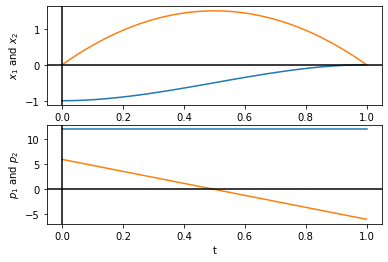

In [10]:
N = 100
tspan = list(np.linspace(t0, tf, N+1))
xf, pf = f.val(t0, x0, p0_sol, tspan, lbda)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(tspan, xf)
ax1.set_xlabel('t')
ax1.set_ylabel('$x_1$ and $x_2$')
ax1.axhline(0, color='k')
ax1.axvline(0, color='k')

ax2 = fig.add_subplot(212)
ax2.plot(tspan, pf)
ax2.set_xlabel('t')
ax2.set_ylabel('$p_1$ and $p_2$')
ax2.axhline(0, color='k')
ax2.axvline(0, color='k')

## Solution from BOCOP

Here is now an illustration of the same problem solved by a so-called 'direct transcription' approach that discretizes the original OCP as a NLP problem.
We shall illustrate the link between the Lagrange multipliers for this problem and the costate of the PMP.

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
import os
import bocop
bocop_root_path = os.path.dirname(bocop.__file__)
print(bocop_root_path)

/Users/caillau/anaconda3/envs/dev/lib/python3.7/site-packages/bocop


In [12]:
problem_path = bocop_root_path+"/examples/smooth_case"
print(problem_path)
clean = 1
debug = 0
graph = 2
verbose = 1
solution = bocop.solve(problem_path, clean, debug, graph, verbose)

/Users/caillau/anaconda3/envs/dev/lib/python3.7/site-packages/bocop/examples/smooth_case
Executing cmake ... OK Executing make ...Error: build step MAKE failed with return 2
Executing  ./bocop  ... 


FileNotFoundError: [Errno 2] No such file or directory: '/Users/caillau/anaconda3/envs/dev/lib/python3.7/site-packages/bocop/examples/smooth_case/problem.sol'

In [ ]:
print("Bocop returns status {} with objective {:2.4g} and constraint violation {:2.4g}".format(solution.status,solution.objective,solution.constraints))
p0 = []
for i in range(solution.dim_state):
  p0.append(solution.costate[i][0])
print("Costate at first time stage (t0+h/2): ",p0)
print("Multipliers for initial conditions: ",solution.boundarycond_multipliers[0:solution.dim_state])